In this notebook, one can find useful information on my work on utility functions for the guide, focus, and alignment (GFA) sensors on DESI. I've included relevant code that I've written over the past summer of 2017, as well as problems I've run into, and general usage of the code. If you have any questions about my work, please don't hesitate to email me at wwang153@stanford.edu or woodywang153@gmail.com. Special thanks to Stephen Bailey for supervising and allowing me to work at LBNL on such an exciting, revolutionary project. 

Note: some of the code in the notebook might have been modified slightly upon being pushed the central desimodel repository in order to avoid redundancies of import statements or for the sake of minor adjustments. 

These were the general goals for the project, and the code in this notebook achieves a majority of them. 

Our project will focus on identifying where stars and galaxies will land on the DESI focal plane for arbitrary pointings of the telescope. Previous work has identified which positioners should point to which astronomical targets for each telescope pointing but more work remains, in particular:
• What stars will land on the 10 “guide focus alignment” (GFA) sensors to be used for focusing the telescope and keeping it tracking (guiding) the sky as the earth rotates during the exposure.
• Do any of our pre-defined pointings not have enough stars? Could small adjustments to the pointing gain more stars?
• Do any of our predefined pointings have overly bright stars that would saturate the detectors and corrupt the data?
• Where do the brightest stars on the sky land for each of our pre-defined pointings?
• Develop visualization tools for understand the positions of stars and galaxies on the focal plane during commissioning and debugging.

The cell below shows my initial work on understanding the focal plane geometry simply by plotting it using matplotlib. %pylab populates the namespace from numpy and matplotlib, making it easier to plot graphs in jupyter notebook, but should not be used in code pushed to the desimodel repository. The function plot_focal_plane() plots the 5000 fiber positioners and the 10 GFA corners, a simple visualization tool to understand the geometry of the focal plane itself. 

In [1]:
import os
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Find the data; these paths are for NERSC
import os
sweep_dir = os.getenv('SWEEP_DIR', '/project/projectdirs/cosmo/data/legacysurvey/dr4/sweep/4.0/')
fiberassign_dir = os.getenv('FIBERASSIGN_DIR', '/project/projectdirs//desi/datachallenge/dc17a-twopct/fiberassign/output/')
assert os.path.isdir(sweep_dir)
assert os.path.isdir(fiberassign_dir)

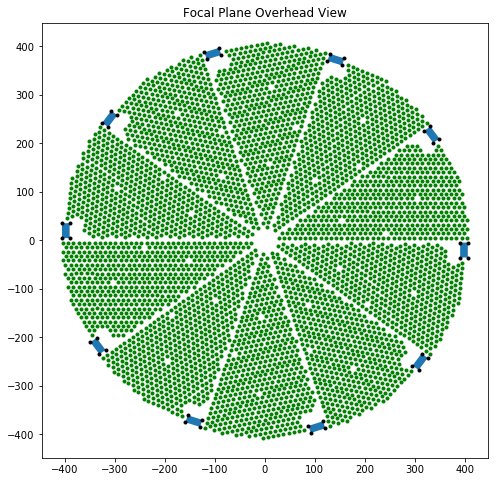

In [3]:
# Uses a rotation matrix to plot the focal plane in mm
def plot_focal_plane():
    '''
    Plots the focal plane with the 5000 fiber positioners and 10 GFAs
    using the initial four corners of the 0th indexed GFA and rotating the
    points by 36 degrees counter-clockwise. Uses the reference projection of 
    the active area for each GFA.
    '''
    import desimodel.io
    # Sets the title of the graph
    title('Focal Plane Overhead View')
    # Plots the location of each of the fiber positioners
    fp = desimodel.io.load_fiberpos()
    plot(fp['X'],fp['Y'], 'g.')
    #x = [318.529, 330.901, 348.947, 336.574]
    #y = [225.702, 234.691, 209.830, 200.841]
    # Experiments with "Reference projection of active area" coordinates
    #x = [318.703, 331.075, 349.121, 336.748]
    #y = [225.816, 234.805, 209.944, 200.955]

    """ Uses the x and y from the petal indexed at 9 so the first petal 
        added to the table is indexed at 0
    [[ 313.24842144 -233.32358331]
     [ 325.62062672 -242.31230077]
     [ 307.55293135 -267.15753816]
     [ 295.18041705 -258.16786964]]"""
    x = [313.24842144, 325.62062672, 307.55293135, 295.18041705]
    y = [-233.32358331, -242.31230077, -267.15753816, -258.16786964]

    # Creates a rotation matrix for 36 degrees counter-clockwise
    rotatemat = numpy.zeros(shape=(2,2))
    rotatemat[0] = [cos(36*pi/180), -sin(36*pi/180)]
    rotatemat[1] = [sin(36*pi/180), cos(36*pi/180)]
    draw_gfas(x, y, rotatemat)
    
# Function that draws the GFAs on the focal plane
def draw_gfas(x, y, rotatemat):
    """
    Draws the 10 GFAs given the initial x and y coordinates of four corners of a GFA
    Parameters
    ----------
    x : Array of four x initial coordinates of the GFA
    y : Array of four y initial coordinates of the GFA
    """
    coord = numpy.zeros(shape=(2,1))
    gfacoord = numpy.zeros(shape=(4, 2))
    oldxcoord = x
    oldycoord = y
    for j in range(10):
        for i in range(4):
            coord[0] = oldxcoord[i]
            coord[1] = oldycoord[i]
            newcoord = matmul(rotatemat, coord)
            oldxcoord[i] = newcoord[0]
            oldycoord[i] = newcoord[1]
            gfacoord[i] = [newcoord[0], newcoord[1]]
            plot(newcoord[0], newcoord[1], 'k.')
        draw_single_gfa(gfacoord)
            
def draw_single_gfa(gfacoord):
    """
    Draws a single GFA given a 4X2 array of coordinates for the four corners of a GFA
    Parameters
    ----------
    gfacoord: 4X2 array of x and y coordinates with each row representing a corner of the GFA
    """
    # Prints all of the GFA coordinates for debugging
    #print(gfaCoord) 
    gfapolygon = Polygon(gfacoord)
    plt.gca().add_patch(gfapolygon)

figure(figsize=(8,8))
plot_focal_plane()

After better understanding of the focal plane geometry, I wrote code to write a .ecsv file with data on each of the GFA's corners. Using the DESI-0530-v13 Excel spreadsheet, I took the 4 corners of the single GFA locations provided and rotated each corner 36 degrees counter-clockwise to define each of the other 10 GFA's corners. The build_gfa_table() function was eventually moved to desimodel.inputs.gfa, with respective unit tests. The table includes information on the GFA's petal number, corner number, x, y, z, q, radius in degrees, and radius in mm. 

In [4]:
# Import statements to run code for debugging
import desimodel.io
import scipy.interpolate

def build_gfa_table(outfile = 'gfa.ecsv'):
    '''
    Builds the GFA table given the data from DESI-0530-v13 Excel spreadsheet
    and writes a .ecsv file using the astropy table library. The data is pulled from
    the "GFALocation" tab on the spreadsheet and from rows 16-23 and columns A-I.
    Parameters
    ----------
    outfile: a default parameter that represents the desired filename which is returned by 
    this function. The filename defaults to "gfa.ecsv" if no parameters are given. 
    '''
    # Uses the reference projection of active area to create data table of GFAs
    from astropy.table import Table
    # Initial x and y coordinates for the GFAs
    """ Uses the x and y from the petal indexed at 9 so the first petal 
        added to the table is indexed at 0
    [[-125.10482863 -370.01790486]
     [-129.83038525 -384.56223777]
     [-159.04283509 -375.05643893]
     [-154.31646944 -360.51151824]]   
    """
    # Data obtained from DESI-0530-v13 Excel spreadsheet
    x = [-125.10482863, -129.83038525, -159.04283509, -154.31646944]
    y = [-370.01790486, -384.56223777, -375.05643893, -360.51151824]
    z = [-17.053, -18.487, -18.631, -17.198]
    rotatemat = numpy.zeros(shape=(2,2))
    rotatemat[0] = [cos(36*pi/180), -sin(36*pi/180)]
    rotatemat[1] = [sin(36*pi/180), cos(36*pi/180)]
    
    # Note: the corners are 0 indexed 
    gfatable = Table(names = ('PETAL', 'CORNER', 'X', 'Y', 'Z', 'Q', 'RADIUS_DEG', 'RADIUS_MM'), 
                 dtype = ('int', 'int', 'float', 'float', 'float', 'float', 'float', 'float'))
    # Sets the units for the GFA table
    gfatable['X'].unit = 'mm'
    gfatable['Y'].unit = 'mm'
    gfatable['Z'].unit = 'mm'
    gfatable['Q'].unit = 'degrees'
    gfatable['RADIUS_DEG'] = 'degrees'
    gfatable['RADIUS_MM'] = 'mm'
    find_gfa_coordinates(x, y, z, gfatable, rotatemat)
    # Saves the table of data as an ecsv file
    gfatable.write(outfile, format='ascii.ecsv')
    
# Function that obtains the x and y coordinates for each corner of the GFAs
def find_gfa_coordinates(x, y, z, gfatable, rotatemat):
    '''
    Finds all the GFA coordinates by rotating the initial coordinates and adding
    the respective coordinates to the gfaTable
    Parameters
    ----------
    x : Array of four x initial coordinates of the GFA
    y : Array of four y initial coordinates of the GFA
    z: Array of four z initial coordinates of the GFA
    gfaTable: Astropy Table object which stores the petal number, corner number, 
    and x, y, and z coordinates in mm within each row
    rotateMat: Rotation matrix to rotate the coordinates 36 degrees counterclockwise
    '''
    coord = numpy.zeros(shape=(2,1))
    gfacoord = numpy.zeros(shape=(4, 2))
    oldxcoord = x
    oldycoord = y
    for j in range(10):
        for i in range(4):
            coord[0] = oldxcoord[i]
            coord[1] = oldycoord[i]
            newcoord = matmul(rotatemat, coord)
            oldxcoord[i] = newcoord[0]
            oldycoord[i] = newcoord[1]
            gfacoord[i] = [newcoord[0], newcoord[1]]
            
            theta = cartesian_to_polar_angle(newcoord[0], newcoord[1])
            # radius is the radius in mm
            radius = np.sqrt(newcoord[0]**2 + newcoord[1]**2)
            # degree is the radius in degrees
            degree = get_radius_deg(newcoord[0], newcoord[1])
            # Could be building the table in O(N^2), which is notably inefficient
            gfatable.add_row([j, i, newcoord[0], newcoord[1], z[i], theta, degree, radius])
            
def get_radius_mm(theta):
    """
    Returns an array of radii in mm given an array of radii in degrees using the platescale data
    relative to the center of the focal plane as (0,0). Supports scalar and vector inputs.
    Parameters
    ----------
    theta: An array that represents the angle from the center of the focal plane
    """
    import scipy.interpolate
    import desimodel.io
    platescale = desimodel.io.load_platescale()
    # Uses a quadratic one-dimensional interpolation to approximate the radius in degrees versus radius in mm
    fn = scipy.interpolate.interp1d(platescale['theta'], platescale['radius'], kind = 'quadratic')
    radius = fn(theta)
    if(np.isscalar(theta)):
        return float(radius)
    else:
        return radius

def get_radius_deg(x, y):
    """
    Returns the radius in degrees given x, y coordinates using the platescale data
    Parameters
    ----------
    x: The x coordinate in mm of a location on the focal plane
    y: The y coordinate in mm of a location on the focal plane
    """
    import scipy.interpolate
    import desimodel.io
    radius = np.sqrt(x**2 + y**2)
    platescale = desimodel.io.load_platescale()
    # Plots are used for debugging.
    #plot(platescale['radius'], platescale['theta'], 'k.')
    #plot(platescale['radius'], platescale['radial_platescale'], 'k.')
    fn = scipy.interpolate.interp1d(platescale['radius'], platescale['theta'], kind = 'quadratic')
    degree = float(fn(radius))
    return degree

def cartesian_to_polar_angle(x, y):
    """
    Given cartesian coordinates, this function returns the polar angle in degrees
    for use in polar coordinates
    Parameters
    ----------
    x: The x coordinate in mm of a location on the focal plane
    y: The y coordinate in mm of a location on the focal plane
    """
    return np.degrees(np.arctan2(y, x))
build_gfa_table()

In the following cell, I've written functions to extract the GFA data with the likes of load_gfa(). load_gfa() has been moved to the desimodel.io Python file to allow users to read the GFA table easily. The following functions are utility plotting functions in order to confirm that the GFA table contains sensible data. The plotting function allows one to visualize the focal plane geometry along with the GFA locations. The plot_gfa(gfa, petal) function also allows one to specifcy which petal of the focal plane they would like to see plotted. These functions are mainly for developing and understanding the data in the GFA table from load_gfa(). It should be noted that most of the functions I've written work with the GFA locations either in RA and Dec or x and y, rather than using the z coordinate or q and s coordinates. Thus, the GFA and focal plane is essentially a 2D projection in my code, rather than the true 3D geometry. 

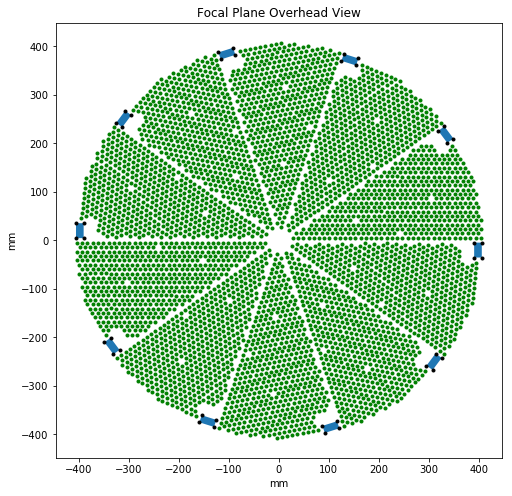

In [5]:
# Follows the style and format of desimodel.io.py
_gfa = None
def load_gfa():
    """Returns GFA table from desimodel/data/focalplane/gfa.ecsv"""
    global _gfa
    from astropy.table import Table
    # os is imported already in the desimodel io.py
    import os
    if _gfa is None:
        gfaFile = os.path.join(os.environ['DESIMODEL'], 'data', 'focalplane', 'gfa.ecsv')
        _gfa = Table.read(gfaFile, format = 'ascii.ecsv')
    return _gfa

def plot_gfa(gfa, petal = None):
    """
    Plots the GFA at a certain petal or all the GFAs depending on 
    the respective parameters. Uses the reference projection of the 
    active area to plot the GFA.
    Parameters
    ----------
    gfa: Astropy Table object with the petal number, corner number, and x, y, z, and q 
    coordinates of the GFAs, as well as the radius in degrees and mm of each corner of the GFAs.
    petal: optional integer parameter which specifies which petal to plot
    """
    title('GFA Overhead View')
    plt.xlabel('mm')
    plt.ylabel('mm')
    gfacoord = numpy.zeros(shape=(4, 2))
    
    if(type(petal) != int and petal != None):
        raise TypeError("Please enter an integer value")
    elif(petal == None):
        counter = 0
        for i in range(40):
            gfacoord[counter % 4] = [gfa['X'][i], gfa['Y'][i]]
            plot(gfa['X'][i], gfa['Y'][i], 'k.')
            counter += 1
            if ((counter % 4) == 0):
                draw_single_gfa(gfacoord)
    elif(petal < 0 or petal > 9):
        raise ValueError("Please enter a petal value between 0 and 9")
    elif(petal <= 9 and petal >= 0):
        index = petal * 4
        for j in range(4):
            gfacoord[j] = [gfa['X'][index], gfa['Y'][index]]
            plot(gfa['X'][index], gfa['Y'][index], 'k.')
            index += 1
        draw_single_gfa(gfacoord)
    else:
        raise Exception("Please enter an integer between 0 and 9")
    plot()
    
def draw_single_gfa(gfacoord):
    """
    Draws a single GFA given a 4X2 array of coordinates for the four corners of a GFA
    Parameters
    ----------
    gfaCoord: 4X2 array of x and y coordinates with each row representing a corner of the GFA
    """
    # Prints all of the GFA coordinates for debugging
    #print(GFAcoord) 
    gfapolygon = Polygon(gfacoord)
    plt.gca().add_patch(gfapolygon)
    
    
def plot_focal_plane():
    """
    Plots a 2D representation of the focal plane with the 5000 fiberpositioners
    and the 10 GFAs
    """
    #%pylab
    #import desimodel.io
    # Plots the location of each of the fiber positioners
    fp = desimodel.io.load_fiberpos()
    plot(fp['X'],fp['Y'], 'g.')
    
    gfa = load_gfa()
    plot_gfa(gfa)
    title('Focal Plane Overhead View')
    
# Debugging lines to test if functions work

#import desimodel.io
#%pylab inline
#fp = desimodel.io.load_fiberpos()
#plot(fp['X'], fp['Y'], 'g.')
#gfa = load_gfa()
#plot_gfa(gfa, 2)

figure(figsize=(8,8))
plot_focal_plane()

The following function, plot_focal_plane_deg() simply plots the focal plane in degrees, rather than in mm, by reading the GFA table in using load_gfa().

PETAL CORNER       X        ...       Q         RADIUS_DEG    RADIUS_MM  
                   mm       ...    degrees                               
----- ------ -------------- ... ------------- ------------- -------------
    0      0  116.279135121 ...  287.31935812 1.54426530071 390.595017971
    0      1  121.005023896 ... 287.345026987  1.5999816328 405.886737469
    0      2   91.784287159 ...  283.02060759 1.60541232205 407.384285137
    0      3  87.0587074141 ... 282.826719301 1.54995479057 392.150643917
    1      0  313.248421438 ...  323.31935812 1.54426530071 390.595017971
    1      1  325.620626724 ... 323.345026987  1.5999816328 405.886737469
    1      2  307.552931346 ...  319.02060759 1.60541232205 407.384285137
    1      3  295.180417053 ... 318.826719301 1.54995479057 392.150643917
    2      0  390.567457688 ...  359.31935812 1.54426530071 390.595017971
    2      1  405.860217581 ... 359.345026987  1.5999816328 405.886737469
  ...    ...            ... ...       

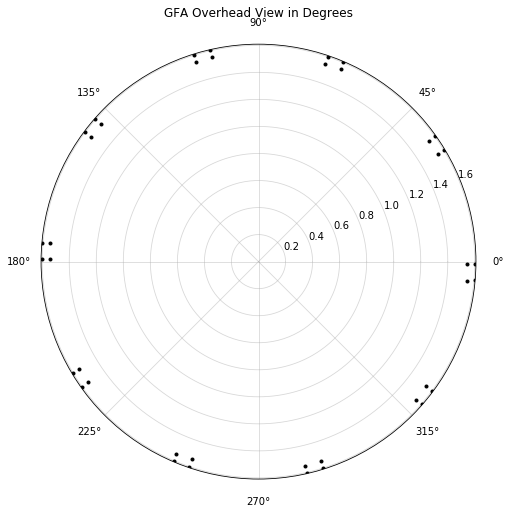

In [6]:
def plot_focal_plane_deg(): 
    """
    Plots the focal plane in degrees using the gfa Table object read in with the astropy library
    """
    import desimodel.io
    # ONLY USED HERE RIGHT NOW BECAUSE LOAD_GFA() HAS NOT BEEN PUSHED
    gfa = desimodel.io.load_gfa()
    
    pyplot.polar()
    title('GFA Overhead View in Degrees')
    # Theta is in degrees
    theta = gfa['Q']
    degree = gfa['RADIUS_DEG']
    print(gfa)
   
    for i in range(40):
        thetaradians = theta[i] * pi / 180
        pyplot.polar(thetaradians, degree[i], 'k.')
        
        # Used for debugging to print the angle in radians and the radius in degrees
        #print(str(theta[i]) + ", " + str(degree[i]))

figure(figsize=(8,8))        
plot_focal_plane_deg()

After creating the .ecsv file to hold the GFA information, in order to determine if a target would be on the GFA, I needed to develop a function to transform x, y coordinates to RA, Dec coordinates, and vice versa. The following code shows xy2radec() and radec2xy(), which use rotation matrices to transform certain coordinates to the new respective coordinate system. 

In [7]:
def xy2radec(telra, teldec, x, y):
    """
    Returns the new RA and Dec of an x, y position on the focal plane
    in the sky given an arbitrary telescope pointing in RA and Dec
    Parameters
    ----------
    telra: a float signifying the telescope's RA pointing in degrees
    teldec: a float signifying the telescope's Dec pointing in degrees
    x: The x coordinate in mm of a location on the focal plane
    y: The y coordinate in mm of a location on the focal plane
    """
    from math import atan2, acos
    
    # radial distance on the focal plane in degrees
    r_deg = get_radius_deg(x, y)
    # print(r_deg)
    # q signifies the angle the position makes with the +x-axis of focal plane
    q = cartesian_to_polar_angle(x, y)
    # print(q)
    
    coord = numpy.zeros(shape=(3,1))
    coord[0] = 1
    
    # Clockwise rotation around the z-axis by the radial distance to a point on the focal plane in radians
    zrotate = numpy.zeros(shape=(3,3))
    r_rad = math.radians(r_deg)
    zrotate[0] = [cos(r_rad), sin(r_rad), 0]
    zrotate[1] = [-sin(r_rad), cos(r_rad), 0]
    zrotate[2] = [0, 0, 1]

    # Counter-clockwise rotation around the x-axis
    xrotate = numpy.zeros(shape=(3,3))
    q_rad = math.radians(q)
    xrotate[0] = [1, 0, 0]
    xrotate[1] = [0, cos(q_rad), -sin(q_rad)]
    xrotate[2] = [0, sin(q_rad), cos(q_rad)]
    
    # Counter-clockwise rotation around y axis by declination of the tile center
    decrotate = numpy.zeros(shape=(3,3))
    teldec_rad = math.radians(teldec)
    decrotate[0] = [cos(teldec_rad), 0, -sin(teldec_rad)]
    decrotate[1] = [0, 1, 0]
    decrotate[2] = [sin(teldec_rad), 0, cos(teldec_rad)]
    
    # Counter-clockwise rotation around the z-axis by the right ascension of the tile center
    rarotate = numpy.zeros(shape=(3,3))
    telra_rad = math.radians(telra)
    rarotate[0] = [cos(telra_rad), -sin(telra_rad), 0]
    rarotate[1] = [sin(telra_rad), cos(telra_rad), 0]
    rarotate[2] = [0, 0, 1]
    
    coord1 = matmul(zrotate, coord)
    coord2 = matmul(xrotate, coord1)
    coord3 = matmul(decrotate, coord2)
    coord4 = matmul(rarotate, coord3)
    
    ra_rad = atan2(coord4[1], coord4[0])
    dec_rad = (pi / 2) - acos(coord4[2] / sqrt((coord4[0]**2) + (coord4[1]**2) + (coord4[2]**2)))
    ra_deg = math.degrees(ra_rad)
    dec_deg = math.degrees(dec_rad)
    # Value can be 360, which should be 0
    ra = ra_deg % 360
    
    
    # MAKE THIS CHANGE AND COMMIT TO GITHUB IN NEW BRANCH BECAUSE RA SHOULD BE BETWEEN 0 AND 360
    if(ra == 360):
        ra = 0 
    return ra, dec_deg
    
    
newra, newdec = xy2radec(8.37, -10.65, -138.345, -333.179)
#simple test case of only moving in ra
#newra1, newdec1 = xy2radec(0, 0, 400, 0)
#newra2, newdec2 = xy2radec(0, 0, 0, 400)
print(newra)
print(newdec)

def radec2xy(telra, teldec, ra, dec):
    
    """
    Returns arrays of the x, y positions of given celestial objects
    on the focal plane given an arbitrary telescope pointing in RA and Dec and
    arrays of the RA and Dec of celestial objects in the sky. Implements the Haversine formula.
    Parameters
    ----------
    telra: a scalar float signifying the telescope's RA pointing in degrees
    teldec: a scalar float signifying the telescope's Dec pointing in degrees
    ra: An array of RA values for locations in the sky
    dec: An array of declination values for locations in the sky
    """
    # Inclination is 90 degrees minus the declination in degrees
    inc = 90 - dec
    x0 = sin(math.radians(inc)) * cos(math.radians(ra))
    y0 = sin(math.radians(inc)) * sin(math.radians(ra))
    z0 = cos(math.radians(inc))
    coord = [x0, y0, z0]
    
    # Clockwise rotation around y axis by declination of the tile center
    decrotate = numpy.zeros(shape=(3,3))
    teldec_rad = math.radians(teldec)
    decrotate[0] = [cos(teldec_rad), 0, sin(teldec_rad)]
    decrotate[1] = [0, 1, 0]
    decrotate[2] = [-sin(teldec_rad), 0, cos(teldec_rad)]
    
    # Clockwise rotation around the z-axis by the right ascension of the tile center
    rarotate = numpy.zeros(shape=(3,3))
    telra_rad = math.radians(telra)
    rarotate[0] = [cos(telra_rad), sin(telra_rad), 0]
    rarotate[1] = [-sin(telra_rad), cos(telra_rad), 0]
    rarotate[2] = [0, 0, 1]
    
    #coord1 = matmul(decrotate, coord)
    #coord2 = matmul(rarotate, coord1)
    
    coord1 = matmul(rarotate, coord)
    coord2 = matmul(decrotate, coord1)
    x = coord2[0]
    y = coord2[1]
    z = coord2[2]
    print(x, y, z)
    
    theta_deg = np.sqrt(y**2 + z**2)
    theta_rad = theta_deg * 180 / np.pi
    #radius = get_radius_mm(theta_rad)
    
    
    p = np.array([8.297E5, -1750.0, 1.394E4, 0.0])
    radius = 0.0
    for i in range(4):
        radius = theta_deg*radius + p[i]


    print(radius)
    testx = radius * -y / theta_deg
    testy = radius * -z / theta_deg
    
    
    return testx, testy
    
    
"""newra, newdec = xy2radec(8.37, -10.65, -138.345, -333.179)
8.927313423598427
-9.324956250231294"""
x, y = radec2xy(8.37, -10.65, 8.927313423598427, -9.324956250231294)
print(x)
print(y)
r = get_radius_deg(x, y)
print(r)
q = cartesian_to_polar_angle(x, y)
print(q)

8.927313423598427
-9.324956250231294
0.99968672009 0.00959826341995 0.0231156876504
360.820536724
-138.368317097
-333.235155026
1.4344442883176411
-112.549556638


It turned out, however, that for some reason, the radec2xy() function would not return exactly the same values as the initial x,y coordinates if attempting a round-trip transformation. Thus, the following function, radecdifference() plots the difference between the intended results and the actual results of the transformation. Due to the inconsistency, I had to modify the radec2xy() formula to use the Haversine formula and slightly different rotation matrices, and the minor inconsistencies were resolved. 

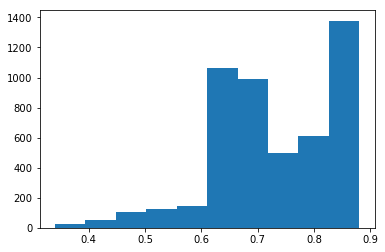

In [8]:
def radecdifference():
    """
    Reads in a file with data from 5000 fiberpositioners at a given telescope pointing
    and graphs a quiver plot and histogram to show the difference in calculations 
    """
    from astropy.io import fits
    from astropy.table import Table
    #import numpy as np
    import desimodel.io
    #%pylab

    tilefile = os.path.join(fiberassign_dir, 'tile_00612.fits')
    tile = Table.read(tilefile, 'FIBER_ASSIGNMENTS')

    #- File bug: TILERA, TILEDEC are arrays of identical values instead of scalars;
    #- just grab element 0
    telra = tile.meta['TILERA'][0]
    teldec = tile.meta['TILEDEC'][0]
    ra = numpy.zeros(5000)
    dec = numpy.zeros(5000)
    # u and v are for the quiver plots, signifying the x and y components of the vectors respectively
    """u = numpy.zeros(5000)
    v = numpy.zeros(5000)"""
    
    for i in range(5000):
        ra[i], dec[i] = xy2radec(telra, teldec, tile['XFOCAL_DESIGN'][i], tile['YFOCAL_DESIGN'][i])
        """u[i] = ra[i] - tile['RA'][i]
        v[i] = dec[i] - tile['DEC'][i]"""
    u = ra - tile['RA']
    v = dec - tile['DEC']
    #q = quiver(tile['RA'], tile['DEC'], 10*u, 10*v)
    hist(sqrt((u*cos(tile['DEC'] * pi / 180))**2 + (v)**2)*3600)

radecdifference()

Below is the new radec2xy() function that consistently converts RA, Dec coordinates back to x,y, completing a round-trip transformation. The function also supports vector inputs. Visualizing and understanding the mathematics behind transforming from x, y coordinates on the focal plane to RA, Dec spherical coordinates was quite confusing for me, and with the help of Stephen Bailey, I was able to understand the transformation through a series of matrix rotations, outlined in the code below. The xy2radec() and radec2xy() code has been moved to desimodel.focalplane. 

In [9]:
# Implements the haversine formula 
def radec2xy(telra, teldec, ra, dec):
    """
    Returns arrays of the x, y positions of given celestial objects
    on the focal plane given an arbitrary telescope pointing in RA and Dec and
    arrays of  the RA and Dec of celestial objects in the sky
    Parameters
    ----------
    telra: a scalar float signifying the telescope's RA pointing in degrees
    teldec: a scalar float signifying the telescope's Dec pointing in degrees
    ra: An array of RA values for locations in the sky
    dec: An array of declination values for locations in the sky
    """
    import numpy as np
    import math
    # Inclination is 90 degrees minus the declination in degrees
    dec = np.asarray(dec)
    inc = 90 - dec
    ra = np.asarray(ra)
    #inc = 90 - dec
    x0 = np.sin(np.radians(inc)) * np.cos(np.radians(ra))
    y0 = np.sin(np.radians(inc)) * np.sin(np.radians(ra))
    z0 = np.cos(np.radians(inc))
    coord = [x0, y0, z0]
    
    # Clockwise rotation around y axis by declination of the tile center
    decrotate = np.zeros(shape=(3,3))
    teldec_rad = np.radians(teldec)
    decrotate[0] = [np.cos(teldec_rad), 0, np.sin(teldec_rad)]
    decrotate[1] = [0, 1, 0]
    decrotate[2] = [-np.sin(teldec_rad), 0, np.cos(teldec_rad)]
    
    # Clockwise rotation around the z-axis by the right ascension of the tile center
    rarotate = np.zeros(shape=(3,3))
    telra_rad = math.radians(telra)
    rarotate[0] = [np.cos(telra_rad), np.sin(telra_rad), 0]
    rarotate[1] = [-np.sin(telra_rad), np.cos(telra_rad), 0]
    rarotate[2] = [0, 0, 1]
    
    coord1 = np.matmul(rarotate, coord)
    coord2 = np.matmul(decrotate, coord1)
    x = coord2[0]
    y = coord2[1]
    z = coord2[2]
    
    newteldec = 0
    newtelra = 0
    ra_rad = np.arctan2(y, x)
    dec_rad = (np.pi / 2) - np.arccos(z / np.sqrt((x**2) + (y**2) + (z**2)))
    radius_rad = 2 * np.arcsin(np.sqrt((np.sin((dec_rad - newteldec) / 2)**2) + ((np.cos(newteldec)) * np.cos(dec_rad) * (np.sin((ra_rad - newtelra) / 2)**2))))
    radius_deg = np.degrees(radius_rad)
    
    q_rad = np.arctan2(-z, -y) 
        
    radius_mm = get_radius_mm(radius_deg)
    x_focalplane = radius_mm * np.cos(q_rad)
    y_focalplane = radius_mm * np.sin(q_rad)
    
    return x_focalplane, y_focalplane

ra = [8.40634632111, 8.927313423598427]
dec = [-9.93649291992, -9.324956250231294]

#x, y = radec2xy(8.37, -10.65, 8.927313423598427, -9.324956250231294)
x, y = radec2xy(8.37, -10.65, ra, dec)
print(x)
print(y)

#8.40634632111 -9.93649291992

"""newra, newdec = xy2radec(8.37, -10.65, -138.345, -333.179)
8.927313423598427
-9.324956250231294"""

[  -8.77510018 -138.345     ]
[-174.88049516 -333.17899999]


'newra, newdec = xy2radec(8.37, -10.65, -138.345, -333.179)\n8.927313423598427\n-9.324956250231294'

After significant amounts of testing, the following functions, on_gfa(), on_tile_gfa(), and get_gfa_targets() are low, mid, and high level functions to retrieve targets on a particular GFA. The functions have all been moved to desimodel.focalplane. 
```
#- example code for the highest level wrapper for how this could be used
#- to loop over sweeps and build tables of GFA targets for each tile
from astropy.table import Table, vstack
import desitarget.io
gfa_targets = list()
for filename in desitarget.io.iter_sweepfiles(root_directory):
    targets = Table.read(filename)
    gfa_targets.append(get_gfa_targets(targets))

gfa_targets = vstack(gfa_targets)
gfa_targets.write('blat.fits')

#- or to write one file per tile:
for tileid in np.unique(gfa_targets['TILEID']):
    ii = (gfa_targets['TILEID'] == tileid)
    outfile = 'gfa_targets-{}.fits'.format(tileid)
    gfa_targets[ii].write(outfile)
```

In [10]:
def on_gfa(telra, teldec, ra, dec, buffer_arcsec = 100):
    """
    Checks if a target is on any of the 10 GFAs given telra, teldec and an array of RA and Dec pointings,
    as well as a parameter for degrees of tolerance one would like to allow. When using
    desimodel.footprint.find_points_in_tiles(tiles, ra, dec, radius) with this function to
    check what points are on the GFAs, the default radius parameter should be set to 1.651 (degrees),
    so that boundary GFA area actually encompasses points normally outside of the tile.
    Parameters:
    telra: The telescope's arbitrary RA pointing
    teldec: The telescope's arbitrary Dec pointing
    ra: An array of RA values for locations in the sky
    dec: An array of declination values for locations in the sky
    buffer_arcsec: A value in arcseconds on the sky of how much tolerance
    one would allow for seeing if a target is on the gfa.
    Returns:
    targetindices: a list  of targets with their respective indices in the
    RA and Dec list passed in that fall on certain GFAs denoted by the index
    in the gfaindices list.
    gfaindices: a list equal in length with the targetindices list with the gfa location 0-9 as each element
    """
    import desimodel.footprint
    # If any calculated area is under the threshold area, it is mathematically impossible
    THRESHOLD_AREA = 469.7
    MIN_TOLERANCE = 0.001
    
    inrangeindices = desimodel.footprint.find_points_radec(telra, teldec, ra, dec, 1.651)
    if not inrangeindices:
        return np.array([]), np.array([])
    inrangeindices = np.asarray(inrangeindices)
    
    targetx, targety = desimodel.focalplane.radec2xy(telra, teldec, ra[inrangeindices], dec[inrangeindices])
    
    x_tolerance, y_tolerance = degrees2xytolerance(buffer_arcsec)
    
    targetindices = []
    gfaindices = []
    
    # x and y hold the 40 new GFA coordinates
    x, y = shift_gfa_points(x_tolerance, y_tolerance)
    # The area boundary's value is the area of the gfa plus some tolerance.
    AREA_BOUNDARY = retrieve_minimum_boundary(x_tolerance, y_tolerance) + MIN_TOLERANCE

    targetx = np.asarray(targetx)
    targety = np.asarray(targety)
    # Method to check if point is inside the rectangle
    for gfaid in range(0, 40, 4):
        # a1 through a4 are edge lengths of the rectangle formed by corners of the GFAs
        a1 = np.sqrt((x[gfaid] - x[gfaid + 1])**2 + (y[gfaid] - y[gfaid + 1])**2)
        a2 = np.sqrt((x[gfaid + 1] - x[gfaid + 2])**2 + (y[gfaid + 1] - y[gfaid + 2])**2)
        a3 = np.sqrt((x[gfaid + 2] - x[gfaid + 3])**2 + (y[gfaid + 2] - y[gfaid + 3])**2)
        a4 = np.sqrt((x[gfaid + 3] - x[gfaid])**2 + (y[gfaid + 3] - y[gfaid])**2)
        # b1 through b4 are the line segments from each corner to the target location
        b1 = np.sqrt((x[gfaid] - targetx)**2 + (y[gfaid] - targety)**2)
        b2 = np.sqrt((x[gfaid + 1] - targetx)**2 + (y[gfaid + 1] - targety)**2)
        b3 = np.sqrt((x[gfaid + 2] - targetx)**2 + (y[gfaid + 2] - targety)**2)
        b4 = np.sqrt((x[gfaid + 3] - targetx)**2 + (y[gfaid + 3] - targety)**2)
        # Calculating areas of triangles using Heron's Formula
        u1 = (a1 + b1 + b2) / 2.0
        u2 = (a2 + b2 + b3) / 2.0
        u3 = (a3 + b3 + b4) / 2.0
        u4 = (a4 + b4 + b1) / 2.0
        area1 = np.sqrt((u1 * (u1 - a1) * (u1 - b1) * (u1 - b2)).clip(0))
        area2 = np.sqrt((u2 * (u2 - a2) * (u2 - b2) * (u2 - b3)).clip(0))
        area3 = np.sqrt((u3 * (u3 - a3) * (u3 - b3) * (u3 - b4)).clip(0))
        area4 = np.sqrt((u4 * (u4 - a4) * (u4 - b4) * (u4 - b1)).clip(0))
        targetarea = area1 + area2 + area3 + area4
         
                     
        assert np.all(targetarea > THRESHOLD_AREA)
                     
        if(any(targetarea < AREA_BOUNDARY) and all(targetarea > THRESHOLD_AREA)):
            newtargetindices = np.where(targetarea < AREA_BOUNDARY)
            targetindices.extend(newtargetindices[0])
            gfaindices.extend([int(gfaid / 4)] * len(newtargetindices[0]))
    return inrangeindices[targetindices], gfaindices

def retrieve_minimum_boundary(x_tolerance, y_tolerance):
    """
    Used as a helper function to the on_gfa function to find the minimum boundary
    area for a point to lie inside a certain GFA given an tolerance in x and y in mm
    Parameters:
    x_tolerance: tolerance in x in mm
    y_tolerance: tolerance in y in mm
    Returns:
    targetarea: the minimum boundary area for the procedure to check if a point is inside the GFA
    """
    import desimodel.footprint
    import desimodel.focalplane
    
    targetx = 116.279135121
    targety = -372.885546514
    #6.644525362152656, -9.055425745149217 GUARANTEED TO BE IN GFA (RA, DEC)
    #x, y = desimodel.focalplane.radec2xy(7.11, -10.53, targetx, targety)
    # If any calculated area is under the threshold area, it is mathematically impossible
    THRESHOLD_AREA = 469.7
    MIN_TOLERANCE = 0.001
    # The area boundary's value is the area of the gfa plus some tolerance.
    
    # x and y hold the 40 new GFA coordinates
    x, y = shift_gfa_points(x_tolerance, y_tolerance)
    
    targetx = np.asarray(targetx)
    targety = np.asarray(targety)
    # Method to check if point is inside the rectangle
    for gfaid in range(0, 4, 4):
        # a1 through a4 are edge lengths of the rectangle formed by corners of the GFAs
        a1 = np.sqrt((x[gfaid] - x[gfaid + 1])**2 + (y[gfaid] - y[gfaid + 1])**2)
        a2 = np.sqrt((x[gfaid + 1] - x[gfaid + 2])**2 + (y[gfaid + 1] - y[gfaid + 2])**2)
        a3 = np.sqrt((x[gfaid + 2] - x[gfaid + 3])**2 + (y[gfaid + 2] - y[gfaid + 3])**2)
        a4 = np.sqrt((x[gfaid + 3] - x[gfaid])**2 + (y[gfaid + 3] - y[gfaid])**2)
        # b1 through b4 are the line segments from each corner to the target location
        b1 = np.sqrt((x[gfaid] - targetx)**2 + (y[gfaid] - targety)**2)
        b2 = np.sqrt((x[gfaid + 1] - targetx)**2 + (y[gfaid + 1] - targety)**2)
        b3 = np.sqrt((x[gfaid + 2] - targetx)**2 + (y[gfaid + 2] - targety)**2)
        b4 = np.sqrt((x[gfaid + 3] - targetx)**2 + (y[gfaid + 3] - targety)**2)
        # Calculating areas of triangles using Heron's Formula
        u1 = (a1 + b1 + b2) / 2.0
        u2 = (a2 + b2 + b3) / 2.0
        u3 = (a3 + b3 + b4) / 2.0
        u4 = (a4 + b4 + b1) / 2.0
        area1 = np.sqrt(u1 * (u1 - a1) * (u1 - b1) * (u1 - b2))
        area2 = np.sqrt(u2 * (u2 - a2) * (u2 - b2) * (u2 - b3))
        area3 = np.sqrt(u3 * (u3 - a3) * (u3 - b3) * (u3 - b4))
        area4 = np.sqrt(u4 * (u4 - a4) * (u4 - b4) * (u4 - b1))
        targetarea = area1 + area2 + area3 + area4
         
        assert np.all(targetarea > THRESHOLD_AREA)
        return targetarea

def degrees2xytolerance(buffer_arcsec):
    """
    Used as a helper function to the on_gfa function to find the tolerance in x and y
    given a tolerance in arcseconds
    Parameters:
    buffer_arcsec: a tolerance in arcseconds for checking if a point is on the GFA
    Returns:
    x_tolerance: tolerance in x in mm
    y_tolerance: tolerance in y in mm
    """
    # Uses the center of a given GFA from DESI-0530-v13 Excel Spreadsheet to find the tolerance
    import desimodel.io
    import scipy.interpolate
    platescale = desimodel.io.load_platescale()
    fn = scipy.interpolate.interp1d(platescale['radius'], platescale['radial_platescale'], kind = 'quadratic')
    fn1 = scipy.interpolate.interp1d(platescale['radius'], platescale['az_platescale'], kind = 'quadratic')
    # Center of a given GFA from DESI-0530-v13 Excel Spreadsheet
    x = 333.738
    y = 217.766
    radius = np.sqrt(x**2 + y**2)
    # Platescales are in units of microns per arcsecond
    r_ps = fn(radius)
    az_ps = fn(radius)
    x_tolerance = buffer_arcsec / (10**3) * r_ps
    y_tolerance = buffer_arcsec / (10**3) * az_ps
    return x_tolerance, y_tolerance

def shift_gfa_points(deltax, deltay):
    """
    Used as a helper function to the on_gfa function to find the new
    GFA locations after incorporating a tolerance in x and y
    Parameters:
    deltax: tolerance in x in mm
    deltay: tolerance in y in mm
    Returns:
    Returns the 40 new GFA locations in x and y
    """
    import numpy as np
    x = [-125.10482863, -129.83038525, -159.04283509, -154.31646944]
    y = [-370.01790486, -384.56223777, -375.05643893, -360.51151824]
    point1 = [x[2], y[2]]
    point2 = [x[1], y[1]]
    vector1 = [(point2[0] - point1[0]), (point2[1] - point1[1])]
    vector2 = [1, 0]
    # Angle between vector1 and vector 2 using dot product
    angle = np.arccos((np.dot(vector1, vector2))/(np.sqrt((vector1[0]**2) + (vector1[1]**2))))
    
    shiftmat = np.zeros(shape=(2,2))
    shiftmat[0] = [np.cos(angle), -np.sin(angle)]
    shiftmat[1] = [np.sin(angle), np.cos(angle)]
    reverseshift= np.zeros(shape=(2,2))
    reverseshift[0] = [np.cos(angle), np.sin(angle)]
    reverseshift[1] = [-np.sin(angle), np.cos(angle)]
    
    # Shifts the initial coordinates to be parallel to the vector [1, 0]
    coord = np.zeros(shape=(2,1))
    oldxcoord = x
    oldycoord = y
    for i in range(4):
        coord[0] = oldxcoord[i]
        coord[1] = oldycoord[i]
        newcoord = np.matmul(shiftmat, coord)
        oldxcoord[i] = newcoord[0]
        oldycoord[i] = newcoord[1]
        if(i == 0 or i == 1):
            x[i] = newcoord[0] + deltax
        else:
            x[i] = newcoord[0] - deltax
        if(i == 1 or i == 2):
            y[i] = newcoord[1] - deltay
        else:
            y[i] = newcoord[1] + deltay
    oldxcoord = x
    oldycoord = y
    for i in range(4):
        coord[0] = oldxcoord[i]
        coord[1] = oldycoord[i]
        newcoord = np.matmul(reverseshift, coord)
        oldxcoord[i] = newcoord[0]
        oldycoord[i] = newcoord[1]
        x[i] = newcoord[0]
        y[i] = newcoord[1]
    
    rotatemat = np.zeros(shape=(2,2))
    rotatemat[0] = [np.cos(np.radians(36)), -np.sin(np.radians(36))]
    rotatemat[1] = [np.sin(np.radians(36)), np.cos(np.radians(36))]
    return find_new_gfa_coordinates(x, y, rotatemat)

def find_new_gfa_coordinates(x, y, rotatemat):
    """
    Used as a helper function to the on_gfa function to find the new
    GFA coordinates given a list of x coordinates, y coordinates, and a rotation matrix
    Parameters:
    x: a list of x coordinates for the GFAs
    y: a list of y coordinates for the GFAs
    rotatemat: a matrix for rotating the respective coordinates
    Returns:
    x_all: a complete list of the 40 GFA x coordinates
    y_all: a complete list of the 40 GFA y coordinates
    """
    import numpy as np
    x_all = np.zeros(shape=(40,1))
    y_all = np.zeros(shape=(40,1))
    coord = np.zeros(shape=(2,1))
    gfacoord = np.zeros(shape=(4, 2))
    oldxcoord = x
    oldycoord = y
    counter = 0
    for j in range(10):
        for i in range(4):
            coord[0] = oldxcoord[i]
            coord[1] = oldycoord[i]
            newcoord = np.matmul(rotatemat, coord)
            oldxcoord[i] = newcoord[0]
            oldycoord[i] = newcoord[1]
            gfacoord[i] = [newcoord[0], newcoord[1]]
            x_all[counter] = newcoord[0]
            y_all[counter] = newcoord[1]
            counter += 1
    return x_all, y_all

def on_tile_gfa(tileid, targets, buffer_arcsec = 100):
    """
    This function takes a tileid, a table of targets, and an optional
    buffer_arcsec parameter to return the indices of targets lying on the GFA
    as well as the GFA locations from 0-9
    Parameters:
    tileid: (int) DESI tile ID, used to lookup telescope (RA, dec)
    targets: table with columns RA, DEC
    Options:
    buffer_arcsec: (float) additional buffer region around GFA to include
    Returns:
    targetindices: list of indices for targets that are covered by GFA number
    in corresponding gfaindices
    gfaindices: list of indices corresponding to 0-9 GFA location
    """
    import desimodel.footprint
    telra, teldec = desimodel.footprint.get_tile_radec(tileid)
    return on_gfa(telra, teldec, targets['RA'], targets['DEC'], buffer_arcsec)

def get_gfa_targets(targets, rfluxlim = 1000, tiles = None, buffer_arcsec = 100):
    """
    This function takes a table of targets, as well as optional parameters
    including a minimum flux in the r-band, a list of tiles, and a buffer in arcseconds
    and returns a table of targets on the GFA satisfying a minimum flux_r
    Parameters:
    targets: table with columns RA, DEC, FLUX_R
    Options:
    rfluxlim: (float) r-band flux limit; default 1000 = rmag 15
    tiles: table of tiles, default to desimodel.io.load_tiles()
    buffer_arcsec: (float) additional buffer region around GFA to include
    Returns subset of input `targets` with additional columns:
    TILEID: (integer) DESI tile ID
    GFA_LOC: (integer) GFA location [0-9]
    Note that the same target could be repeated with different TILEID, GFA_LOC
    Note also that the function returns an empty list if no targets are on any GFAs or of sufficient brightness
    """
    if(tiles is None):
        import desimodel.io
        tiles = desimodel.io.load_tiles()
    import desimodel.footprint
    points = desimodel.footprint.find_points_in_tiles(tiles, targets['RA'], targets['DEC'])
    alltargetindices = []
    tileidlist = []
    gfaidlist = []
    # Checks if the flux_r meets a minimum threshold
    brightindices = np.where(targets['FLUX_R'] > rfluxlim)
    if(brightindices[0].size == 0):
        return []
    counter = 0
    for lists in points:
        if lists:
            tileid = tiles[counter]['TILEID']
            targetindices, gfaindices = on_tile_gfa(tileid, targets[brightindices[0]], buffer_arcsec)
            tileidlist.extend([tileid] * len(targetindices))
            alltargetindices.extend(targetindices)
            gfaidlist.extend(gfaindices)
        counter += 1
    validtargets = targets[brightindices[0]][alltargetindices]
    tileidlist = np.asarray(tileidlist)
    gfaidlist = np.asarray(gfaidlist)
    validtargets['TILEID'] = tileidlist
    validtargets['GFA_LOC'] = gfaidlist
    return validtargets

The code below simply plots the an arbitray focal plane showing the tile in blue, the GFA boundary including the buffer in red, and the actual GFA boundary in green. 

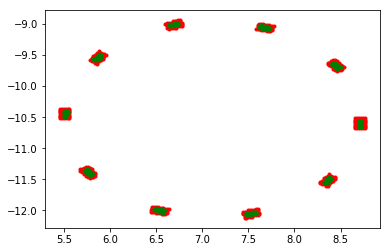

In [11]:
import matplotlib.pyplot as plt
import numpy as np
#telra and teldec = 7.11 -10.53
#tileid is 23658
mindec = -12.5
maxdec = -7
minra = 5.4
maxra = 8.9
ra = []
dec = []
import desimodel.focalplane
import desimodel.footprint
import desimodel.io
tiles = desimodel.io.load_tiles()

while mindec < maxdec:
    startra = minra
    while startra < maxra:
        ra.append(startra)
        dec.append(mindec)
        startra += .02
    mindec += .02

ra = np.asarray(ra)
dec = np.asarray(dec)

points = desimodel.footprint.find_points_radec(7.1, -10.5, ra, dec, 1.651)

#plt.plot(ra[points], dec[points], 'b.')
targetindices, gfaindices = on_gfa(7.11, -10.53, ra, dec, 100)
plt.plot(ra[targetindices], dec[targetindices], 'r.')
targetindices, gfaindices = on_gfa(7.11, -10.53, ra, dec, 0)
plt.plot(ra[targetindices], dec[targetindices], 'g.')
plt.show()

The function plot_gfa_targets() is a visualization tool that plots all targets in a given table that are on a GFA satisfying a minimum flux in the r-band in blue. It plots anything that exceeds a maximum flux in the r-band in red. This visualization tool may be useful in determining if a given GFA has too many extremely bright targets that may over-saturate the images. 

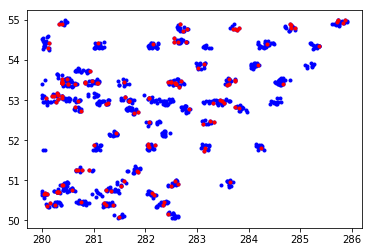

In [12]:
def plot_gfa_targets(targets, rfluxlim = 1000, rfluxmax = 10000, tiles = None, buffer_arcsec = 100, tileid = None):
    """
    This function takes a table of targets, as well as optional parameters 
    including a minimum flux in the r-band, a list of tiles, a buffer in arcseconds, 
    and a tileid number and uses blue to plot the targets on the GFA satisfying a minimum flux_r
    on either a specific tileid in the targets table, or all the targets on any tileid returned 
    by get_gfa_targets. It also uses red to plot all targets on the GFA above a maximum flux_r.
    Parameters:
    targets: table with columns RA, DEC, FLUX_R
    Options:
    rfluxlim: (float) r-band flux limit; default 1000 = rmag 15
    rfluxmax: (float) r-band flux maximum; default 5000
    tiles: table of tiles, default to desimodel.io.load_tiles()
    buffer_arcsec: (float) additional buffer region around GFA to include
    tileid: (int) a unique indentifier for a tile pointing
    """
    import matplotlib.pyplot as plt
    if(tiles is None):
        import desimodel.io
        tiles = desimodel.io.load_tiles()
    valid = get_gfa_targets(targets, rfluxlim, tiles, buffer_arcsec)
    if(tileid is None):
        plt.plot(valid['RA'], valid['DEC'], 'b.')
        brightindices = np.where(valid['FLUX_R'] > rfluxmax)
        plt.plot(valid[brightindices[0]]['RA'], valid[brightindices[0]]['DEC'], 'r.')
    else:    
        indices = np.where(valid['TILEID'] == tileid)
        plt.plot(valid[indices]['RA'], valid[indices]['DEC'], 'b.')
        brightindices = np.where(valid[indices]['FLUX_R'] > rfluxmax)
        plt.plot(valid[indices][brightindices[0]]['RA'], valid[indices][brightindices[0]]['DEC'], 'r.')
    plt.show()
    
from astropy.io import fits
from astropy.table import Table
sweepname = 'sweep-280p050-290p055.fits'
sweep = Table.read(os.path.join(sweep_dir, sweepname))

plot_gfa_targets(sweep, tileid = None)

To find the brightest object on the GFA, which would likely over-saturate images, run the following code with a modified root directory with all the current sweep files. This can be done with NERSC to make the process quicker. Work on the GFA should probably continue with using this function to find problematic targets. Also, a function to find any GFAs without targets should be written. 

In [13]:
def get_all_gfa_targets(sweep_dir):
    #- example code for the highest level wrapper for how this could be used
    #- to loop over sweeps and build tables of GFA targets for each tile
    from astropy.table import Table, vstack
    from astropy.io import fits
    import desitarget.io
    import desimodel.focalplane
    import numpy as np
    gfa_targets = list()
    for filename in desitarget.io.iter_sweepfiles(sweep_dir):
        targets = Table.read(filename)
        try:
            on_gfa_targets = desimodel.focalplane.get_gfa_targets(targets)
        except:
            print(filename)
            break
        if(type(on_gfa_targets) is not list):
            gfa_targets.append(on_gfa_targets)

    gfa_targets = vstack(gfa_targets)
    return gfa_targets


#-----
gfa_targets = get_all_gfa_targets(sweep_dir)
index = np.where(gfa_targets['FLUX_R'] == max(gfa_targets['FLUX_R']))
print(gfa_targets[index])

RELEASE BRICKID BRICKNAME OBJID ... SHAPEEXP_E2 SHAPEEXP_E2_IVAR TILEID GFA_LOC
------- ------- --------- ----- ... ----------- ---------------- ------ -------
   4000  592726  2651p522   858 ...         0.0              0.0 2219.0     2.0


Conclusions: 
Further development may be necessary once the GFAs have actually been built, and thus the GFA table should be updated, which can be done manually or through updating the code in build_gfa_table(). A threshold magnitude for flux in the r-band for targets should be determined, and a simple insertion of np.where(valid['FLUX_R'] > rfluxmax) can be put into the get_gfa_targets() function to alert observers of any targets that may potentially over-saturate the images. Since DESI is constantly evolving, I've tried to make my code heavily documented with comments, so that if changes need to be made, it will be simple to do so. Thanks again to Stephen Bailey for helping make my summer productive and engaging! Again, if any part of this notebook is confusing, I'd be happy to clear things up via email at woodywang153@gmail.com.

Onwards,
Woodrow Wang
Stanford University